## Homework 08: Conceptual exercises

### MACS 30100 Perspectives on Computational Modeling, Dr. Soltoff

Ellen Hsieh

4 Mar 2019

In [1]:
import time
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Cost functions for classification trees

In [2]:
# calculate the value of classification error, Gini index, and cross entropy
p = np.linspace(0, 1, 100)
err_rate = 1 - np.maximum(p, (1 - p))
gini_index = p * (1 - p) * 2
cross_entropy = - (p * np.log(p) + (1 - p) * np.log((1 - p)))

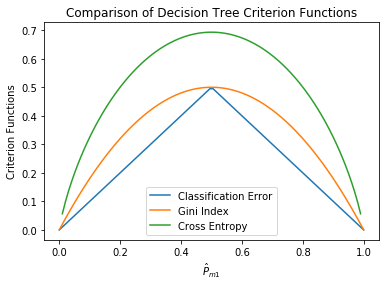

In [3]:
# plot the comparison of decision tree functions
plt.plot(p, err_rate, label='Classification Error')
plt.plot(p, gini_index, label='Gini Index')
plt.plot(p, cross_entropy, label='Cross Entropy')
plt.title('Comparison of Decision Tree Criterion Functions')
plt.xlabel(r'$\hat P_{m1}$')
plt.ylabel('Criterion Functions')
plt.legend()
plt.show()

When growing a decision tree, either Gini index or cross-entropy are more suitable to use becuase they are more sensitive to node purity. However, when it comes to pruning a decision tree, classification error rate is more appropriate to use since we want a more accurate prediction. 

### Predictions from tree-aggregation methods

In [4]:
# 10 estimates of Pr(Class is red|X)
p = np.array([0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75])

In [5]:
# using majority vote approach
np.sum(p > 0.5) / len(p)

0.6

The final classification under the majority vote approach is "Red" since the prediction number of red is greater than green.

In [6]:
# using the average of probabilities
np.mean(p)

0.45

The final classification based on the average probability is "Green" because the probability is less than 0.5.

Using the majority vote approach, the predicted probability of belonging to "Red" is 0.6. As for averaging the predicted probabilities, the probability is 0.45. The latter approach is correct. Suppose the true probability of belonging to the “Red” class at x is 0.75, and each of the bagged classifiers accurately predict “Red”, then $P_{Red}(x) = 1$, which is incorrect. Therefore, averaging the predicted probabilities is a more reliable approach. 

### Standardization using xgboost

In [7]:
# load the data
gss_train = pd.read_csv('./data/gss_train.csv')
gss_test = pd.read_csv('./data/gss_test.csv')

# split the training/testing predictors and response var
x_train = gss_train.drop(['egalit_scale'], axis=1)
y_train = gss_train[['egalit_scale']]
x_test = gss_test.drop(['egalit_scale'], axis=1)
y_test = gss_test[['egalit_scale']]

In [8]:
# seperate dummy and numerical columns
dummy_cols  = []
num_cols = []

for col in x_train.columns:
    if np.array_equal(np.unique(x_train[col]), np.array([0, 1])):
        dummy_cols.append(col)
    else:
        num_cols.append(col)

x_train_dummy = x_train[dummy_cols]
x_train_num = x_train[num_cols]

In [9]:
# standardize the numeric columns
scaler = StandardScaler()
scaler.fit(x_train_num)
scalered_x_train_num = scaler.transform(x_train_num)

# get the scaled and unscaled gss training dataset
gss_train_scaled = np.concatenate(((scalered_x_train_num), x_train_dummy), axis=1)
gss_train_unscaled = np.concatenate((x_train_num.values, x_train_dummy), axis=1)

In [10]:
# using 5-fold CV to get MSE for scaled and unscaled dataset
kf = KFold(n_splits=5, shuffle=True)

mses_scaled = []
mses_unscaled = []
time_scaled = []
time_unscaled = []

for train_index, test_index in kf.split(gss_train_scaled):   
    x_tr_scaled, x_te_scaled = gss_train_scaled[train_index], gss_train_scaled[test_index]
    x_tr_unscaled, x_te_unscaled = gss_train_unscaled[train_index], gss_train_unscaled[test_index]
    y_tr, y_te = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # training the model with 1000 trees
    clf = xgb.XGBRegressor(n_estimators=1000)
    start = time.time()
    clf.fit(x_tr_scaled, y_tr)
    y_pred_scaled = clf.predict(x_te_scaled)    
    end = time.time()
    time_scaled.append(end - start)
    mses_scaled.append(mse(y_te, y_pred_scaled))
    
    start = time.time()
    clf.fit(x_tr_unscaled, y_tr)
    y_pred_unscaled = clf.predict(x_te_unscaled)    
    end = time.time()
    time_unscaled.append(end - start)
    mses_unscaled.append(mse(y_te, y_pred_unscaled))

In [11]:
# get the 5-folfCV MSE and the runtime for both models
print('''
The average 5-fold CV MSE of the scaled model is: {:.3f} 
The average 5-fold CV MSE of the unscaled model is: {:.3f} 
The average runtime of the scaled model is: {:.3f} 
The average runtime of the unscaled model is: {:.3f} 
'''.format(np.mean(mses_scaled), np.mean(mses_unscaled), np.mean(time_scaled), np.mean(time_unscaled)))


The average 5-fold CV MSE of the scaled model is: 66.948 
The average 5-fold CV MSE of the unscaled model is: 66.911 
The average runtime of the scaled model is: 3.372 
The average runtime of the unscaled model is: 3.380 



Both scaled and unscaled model perform similarly in terms of MSE and computational efficiency. This is becuase the bianry decision tree algorithm are not influneced by the scaling of the variables. Therefore, standardizing the variables has no impact on the performance of the model.